In [16]:
import tensorflow as tf
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, add , Input,GlobalAveragePooling2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.regularizers import l2
from keras.models import load_model
from sklearn.metrics import confusion_matrix
import pandas as pd
from keras.models import Model
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint
import seaborn as sns
import numpy as np
import os
import matplotlib.pyplot as plt
plt.rcParams['axes.unicode_minus'] = False
plt.style.use('fivethirtyeight')
%matplotlib inline

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

170498071/170498071 [==============================] - 2s 0us/step
x_train shape: (50000, 32, 32, 3)
50000 train samples
10000 test samples


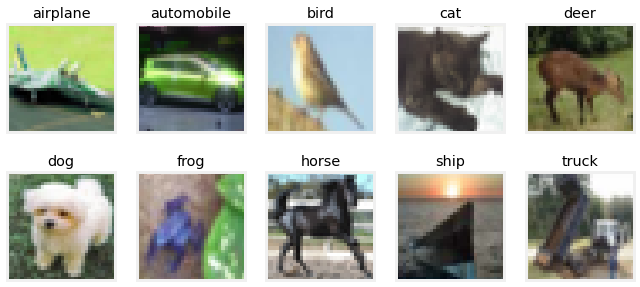

In [5]:
# plotting some random 10 images

class_names = ['airplane','automobile','bird','cat','deer',
               'dog','frog','horse','ship','truck']

fig = plt.figure(figsize=(10,5))
for i in range(10):
    ax = fig.add_subplot(2, 5, 1 + i, xticks=[], yticks=[])
    idx = np.where(y_train[:]==i)[0]
    features_idx = x_train[idx,::]
    img_num = np.random.randint(features_idx.shape[0])
    im = (features_idx[img_num,::])
    ax.set_title(class_names[i])
    plt.imshow(im)
plt.show()

In [6]:
# Convert class vectors to binary class matrices.
y_train = tf.keras.utils.to_categorical(y_train, 10)
y_test = tf.keras.utils.to_categorical(y_test, 10)

In [7]:
def ResidualBlock(inputs, filters, stride=1):
    x = Conv2D(filters, (3, 3), strides=stride, padding='same')(inputs)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(filters, (3, 3), strides=1, padding='same')(x)
    x = BatchNormalization()(x)
    shortcut = inputs
    if stride != 1 or inputs.shape[-1] != filters:
        shortcut = Conv2D(filters, (1, 1), strides=stride)(inputs)
    x = add([x, shortcut])
    x = Activation('relu')(x)
    return x


In [ ]:
def create_model(input_shape, num_classes, num_blocks):
    inputs = Input(shape=input_shape)
    x = Conv2D(64, (3, 3), strides=1, padding='same')(inputs)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    for i in range(num_blocks):
        x = ResidualBlock(x, 64)
    x = Conv2D(64, (3, 3), strides=1, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(num_classes, (1, 1), strides=1)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = GlobalAveragePooling2D()(x)
    outputs = Activation('softmax')(x)
    model = Model(inputs, outputs)
    return model

input_shape = (32, 32, 3)
num_classes = 10
num_blocks = 6
model = create_model(input_shape, num_classes, num_blocks)
model.compile(loss='categorical_crossentropy',
              optimizer=Adam(learning_rate=0.001),
              metrics=['accuracy'])
model.summary()

In [ ]:
!pip install visualkeras

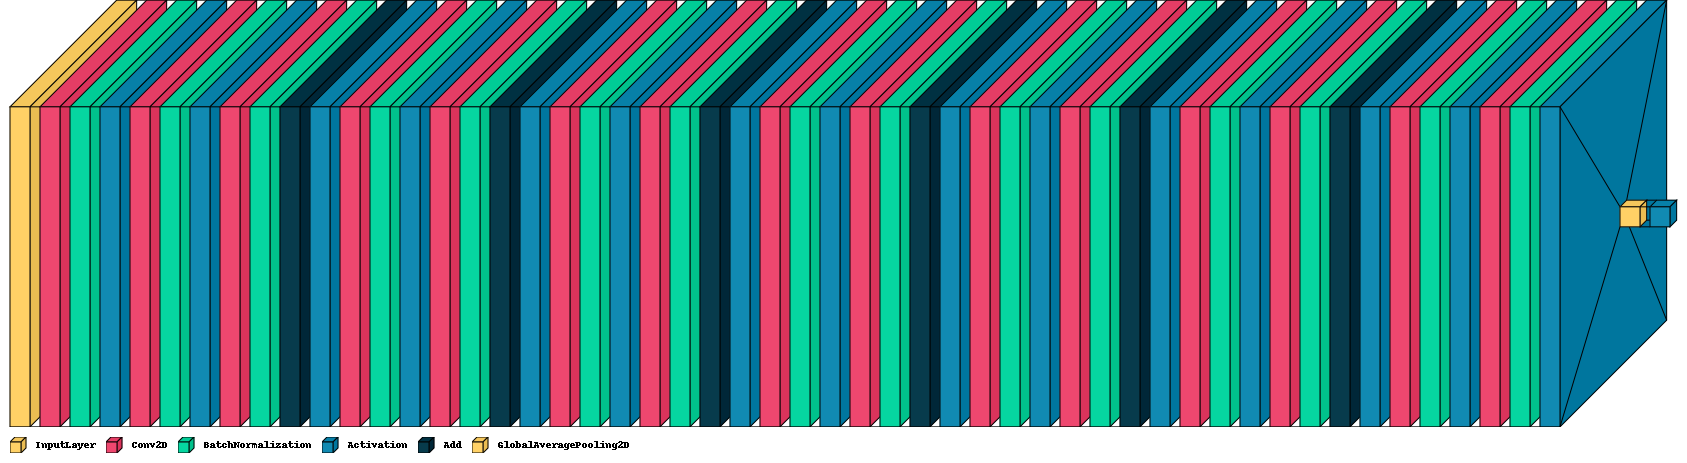

In [29]:
# Visualizing our model (Hidden Input)
import visualkeras
visualkeras.layered_view(model, scale_xy=10, legend=True)

In [9]:
# early_stopping = tf.keras.callbacks.EarlyStopping(
#     monitor='val_loss', 
#     verbose=1,
#     patience=20, # number of epochs that didnt bring an improvement 
#     mode='min',
#     restore_best_weights=True)

checkpoint = ModelCheckpoint(filepath='/content/drive/My Drive/best_model_cifar10.h5',
                                   monitor='val_accuracy', 
                                   mode = 'max',
                                   save_best_only=True,
                                   verbose=1)


history = model.fit(x_train, y_train,
                    validation_data=[x_test, y_test], 
                    epochs=50,
                    batch_size=32,
                    callbacks=[checkpoint], 
                    verbose=1)

Epoch 1/50
1563/1563 [==============================] - ETA: 0s - loss: 1.5946 - accuracy: 0.4684
Epoch 1: val_accuracy improved from -inf to 0.49730, saving model to /content/drive/My Drive/best_model_cifar10.h5
1563/1563 [==============================] - 67s 37ms/step - loss: 1.5946 - accuracy: 0.4684 - val_loss: 1.4926 - val_accuracy: 0.4973
Epoch 2/50
1563/1563 [==============================] - ETA: 0s - loss: 1.1415 - accuracy: 0.6247
Epoch 2: val_accuracy improved from 0.49730 to 0.60430, saving model to /content/drive/My Drive/best_model_cifar10.h5
1563/1563 [==============================] - 62s 40ms/step - loss: 1.1415 - accuracy: 0.6247 - val_loss: 1.1676 - val_accuracy: 0.6043
Epoch 3/50
1563/1563 [==============================] - ETA: 0s - loss: 0.9443 - accuracy: 0.6912
Epoch 3: val_accuracy did not improve from 0.60430
1563/1563 [==============================] - 64s 41ms/step - loss: 0.9443 - accuracy: 0.6912 - val_loss: 1.1954 - val_accuracy: 0.5977
Epoch 4/50
1562/1

Best epoch accuracy: 44
Best epoch loss: 33


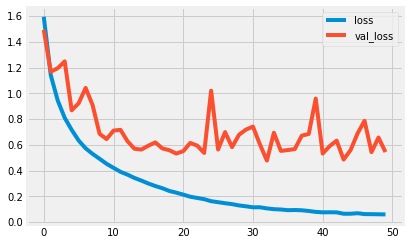

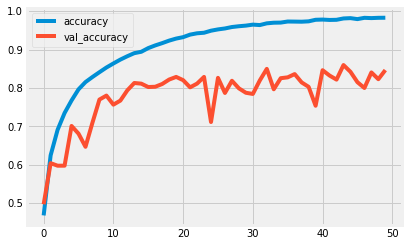

In [11]:
# # #determine best epoch
val_acc_per_epoch = history.history['val_accuracy']
best_epoch = val_acc_per_epoch.index(max(val_acc_per_epoch)) + 1
print('Best epoch accuracy: %d' % (best_epoch,))
val_acc_per_epoch = history.history['val_loss']
best_epoch = val_acc_per_epoch.index(min(val_acc_per_epoch)) + 1
print('Best epoch loss: %d' % (best_epoch,))

# #plot loss
history_frame = pd.DataFrame(history.history)
history_frame.loc[:, ['loss', 'val_loss']].plot()
history_frame.loc[:, ['accuracy', 'val_accuracy']].plot();

loss :  0.48595181107521057
accuracy :  0.8596000075340271



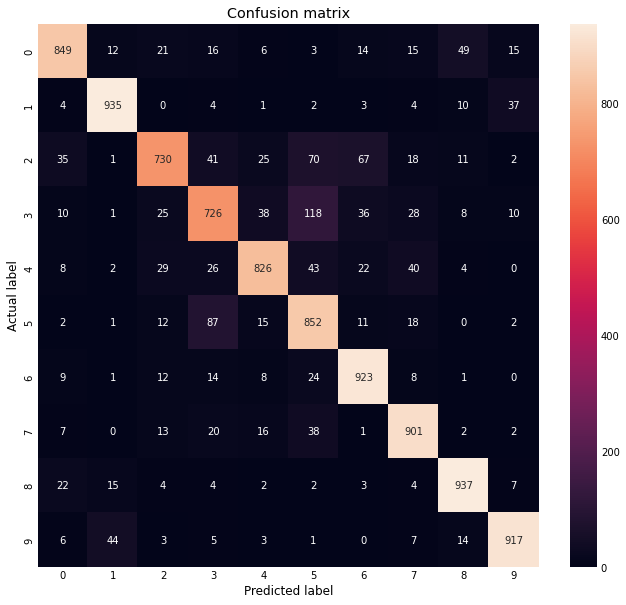

In [27]:
#get best model from Training
model=load_model('/content/drive/My Drive/best_model_cifar10.h5')

#predict 

def plot_cm(labels, predictions):
  cm = confusion_matrix(labels, predictions)
  plt.figure(figsize=(10,10))
  sns.heatmap(cm, annot=True, fmt="d")
  plt.title('Confusion matrix')
  plt.ylabel('Actual label')
  plt.xlabel('Predicted label')

baseline_results = model.evaluate((x_test), y_test,verbose=0)
for name, value in zip(model.metrics_names, baseline_results):
  print(name, ': ', value)
print()

test_predictions_baseline = model.predict((x_test),verbose=0)
predicted_classes = test_predictions_baseline.argmax(axis=1)
plot_cm(y_test.argmax(axis=1), predicted_classes)
